# Possibly add to poetry

In [ ]:
# conda install geopandas
# conda install matplotlib

# Imports

In [1]:
import geopandas
import pandas as pd
from matplotlib import pyplot as plt

from pystatis import Table

# Bundeslaender-Ebene

## load shape file

In [2]:

path_to_data = "data/VG2500_LAN.shp"
gdf = geopandas.read_file(path_to_data)


In [3]:
gdf.loc[:,'area']=gdf.area

In [ ]:
?gdf.plot

<Axes: >

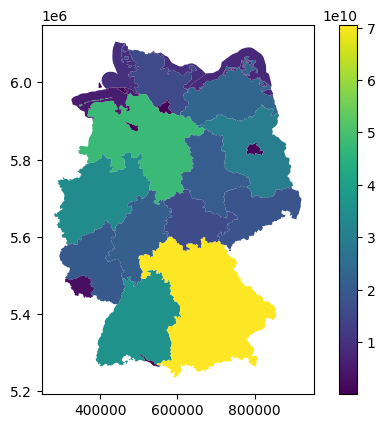

In [5]:
gdf.plot('area',legend=True)

In [6]:
gdf.GEN

0               Schleswig-Holstein
1                          Hamburg
2                    Niedersachsen
3                           Bremen
4              Nordrhein-Westfalen
5                           Hessen
6                  Rheinland-Pfalz
7                Baden-Württemberg
8                           Bayern
9                         Saarland
10                          Berlin
11                     Brandenburg
12          Mecklenburg-Vorpommern
13                         Sachsen
14                  Sachsen-Anhalt
15                       Thüringen
16              Schleswig-Holstein
17                         Hamburg
18                   Niedersachsen
19                   Niedersachsen
20                          Bremen
21          Mecklenburg-Vorpommern
22    Baden-Württemberg (Bodensee)
23               Bayern (Bodensee)
Name: GEN, dtype: object

In [7]:
gdf.AGS

0     01
1     02
2     03
3     04
4     05
5     06
6     07
7     08
8     09
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    01
17    02
18    03
19    03
20    04
21    13
22    08
23    09
Name: AGS, dtype: object

## load data from Regionalstatistik

In [8]:
students = Table(name="21311-01-01-4")
population = Table(name="12411-01-01-4")

In [9]:
students.get_data(startyear=2015)
population.get_data()

Die Tabelle ist zu groß, um direkt abgerufen zu werden. Es wird eine Verarbeitung im Hintergrund gestartet.
/Users/miay/git/github/CorrelAid/pystatis/src/pystatis/table.py:118: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(data_buffer, sep=";", na_values=["...", ".", "-", "/", "x"])


## determine ratio of international students per year and region

In [ ]:
total_sex = students.data.Geschlecht == "Insgesamt"
all_subjects = students.data["Fächergruppe (mit Insgesamt)"] == "Insgesamt"

In [33]:
df = students.data[total_sex & all_subjects]
df[(df["Amtlicher Gemeindeschlüssel (AGS)"] == "07131") & (df["Semester"] == "WS 2015/16")]

,Semester,Amtlicher Gemeindeschlüssel (AGS),Kreise und kreisfreie Städte,Geschlecht,Nationalität (inkl. insgesamt),Fächergruppe (mit Insgesamt),Studierende_(im_Kreisgebiet)__Anzahl
15129,WS 2015/16,07131,"Ahrweiler, Landkreis",Insgesamt,Insgesamt,Insgesamt,2887.0
15139,WS 2015/16,07131,"Ahrweiler, Landkreis",Insgesamt,Ausländer/-innen,Insgesamt,300.0
15149,WS 2015/16,07131,"Ahrweiler, Landkreis",Insgesamt,Deutsche,Insgesamt,2587.0


In [50]:
total_sex = students.data.Geschlecht == "Insgesamt"
all_subjects = students.data["Fächergruppe (mit Insgesamt)"] == "Insgesamt"

ratio_international = (
    students.data[total_sex & all_subjects]
    .groupby(by=["Kreise und kreisfreie Städte", "Amtlicher Gemeindeschlüssel (AGS)", "Semester"])[
        "Studierende_(im_Kreisgebiet)__Anzahl"
    ]
    .apply(lambda x: (x.iloc[1] / x.iloc[0] if len(x) == 3 else None))
)
ratio_international.rename("ratio_international", inplace=True)
ratio_international

Kreise und kreisfreie Städte  Amtlicher Gemeindeschlüssel (AGS)  Semester  
      Aachen, Kreis           5354                               WS 2017/18         NaN
                                                                 WS 2019/20         NaN
                                                                 WS 2021/22         NaN
                              05354                              WS 2015/16         NaN
                                                                 WS 2016/17         NaN
                                                                                 ...   
Deutschland                   DG                                 WS 2017/18    0.131665
                                                                 WS 2018/19    0.137599
                                                                 WS 2019/20    0.142371
                                                                 WS 2020/21    0.141446
                                            

In [51]:
ratio_international = pd.DataFrame(ratio_international)
ratio_international["year"] = [int(semester[3:7]) for semester in ratio_international.index.get_level_values(2)]
ratio_international = ratio_international.reset_index()
ratio_international = ratio_international.sort_values(["Kreise und kreisfreie Städte", "year"])

In [52]:
ratio_international.query("`Kreise und kreisfreie Städte` == '  Bayern'")

,Kreise und kreisfreie Städte,Amtlicher Gemeindeschlüssel (AGS),Semester,ratio_international,year
3658,Bayern,09,WS 2015/16,0.114288,2015
3659,Bayern,09,WS 2016/17,0.120434,2016
3655,Bayern,9,WS 2017/18,0.128948,2017
3660,Bayern,09,WS 2018/19,0.139124,2018
3656,Bayern,9,WS 2019/20,0.147157,2019
3661,Bayern,09,WS 2020/21,0.150818,2020
3657,Bayern,9,WS 2021/22,0.167680,2021


## plot time evolution

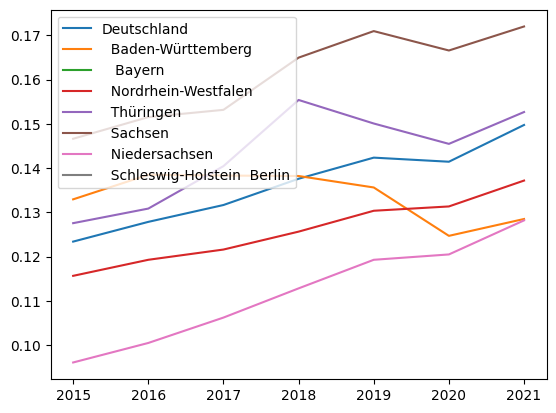

In [54]:
for region in [
    "Deutschland",
    "  Baden-Württemberg",
    "   Bayern",
    "  Nordrhein-Westfalen",
    "  Thüringen",
    "  Sachsen",
    "  Niedersachsen",
    "  Schleswig-Holstein" "  Berlin",
]:
    plt.plot(
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].year,
        ratio_international[ratio_international["Kreise und kreisfreie Städte"] == region].ratio_international,
        label=region,
    )
plt.legend()

## merge with geodataframe and plot

In [55]:
year = 2015

gdf_merged = pd.merge(
    left=gdf,
    right=ratio_international[ratio_international.year == year],
    left_on="AGS",
    right_on="Amtlicher Gemeindeschlüssel (AGS)",
)
gdf_merged.ratio_international

0     0.075698
1     0.111490
2     0.096085
3     0.145414
4     0.115662
5     0.138366
6     0.104924
7     0.132946
8     0.114288
9     0.138887
10    0.180502
11    0.151432
12    0.073169
13    0.146635
14    0.125651
15    0.127564
16    0.075698
17    0.111490
18    0.096085
19    0.096085
20    0.145414
21    0.073169
22    0.132946
23    0.114288
Name: ratio_international, dtype: float64

<Axes: >

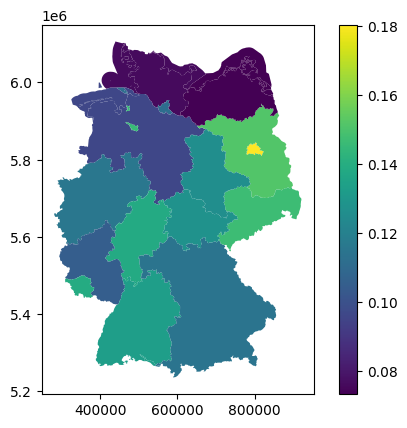

In [56]:
gdf_merged.plot("ratio_international", legend=True, missing_kwds={"color": "lightgrey"})

<Axes: >

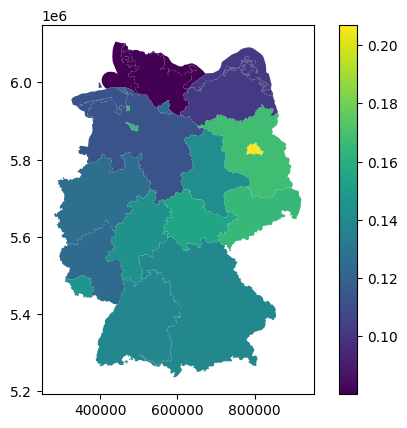

In [57]:
year = 2018
gdf_merged = pd.merge(
    left=gdf,
    right=ratio_international[ratio_international.year == year],
    left_on="AGS",
    right_on="Amtlicher Gemeindeschlüssel (AGS)",
)
gdf_merged.ratio_international
gdf_merged.plot("ratio_international", legend=True, missing_kwds={"color": "lightgrey"})

<Axes: >

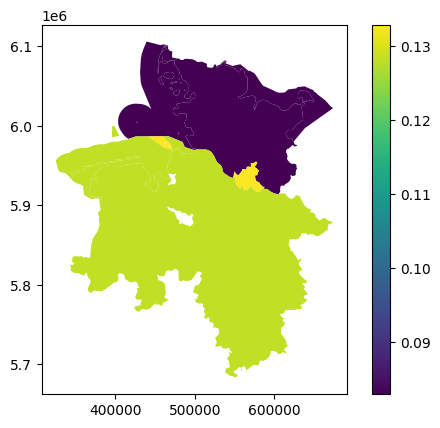

In [58]:
year=2021
gdf_merged = pd.merge(
    left=gdf,
    right=ratio_international[ratio_international.year == year],
    left_on="AGS",
    right_on="Amtlicher Gemeindeschlüssel (AGS)",
)
gdf_merged.ratio_international
gdf_merged.plot('ratio_international',legend=True, missing_kwds={'color': 'lightgrey'})

# Landkreisebene

## load shape file

In [59]:
path_to_data = "data/VG2500_KRS.shp"
gdf = geopandas.read_file(path_to_data)


DriverError: data/VG2500_KRS.shp: No such file or directory

In [166]:
gdf.loc[:,'area']=gdf.area

<Axes: >

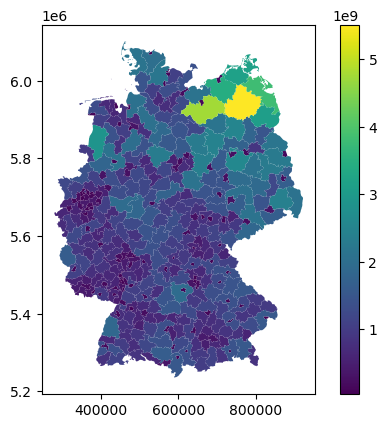

In [167]:
gdf.plot('area',legend=True)

In [169]:
gdf.GEN

0                 Flensburg
1                      Kiel
2                    Lübeck
3                Neumünster
4              Dithmarschen
               ...         
395     Saalfeld-Rudolstadt
396    Saale-Holzland-Kreis
397        Saale-Orla-Kreis
398                   Greiz
399        Altenburger Land
Name: GEN, Length: 400, dtype: object

In [170]:
gdf.AGS = gdf.AGS.astype(str)

## fix city-states

In [171]:
students.data.loc[students.data['Kreise und kreisfreie Städte_Code']=='11','Kreise und kreisfreie Städte_Code']='11000'
students.data.loc[students.data['Kreise und kreisfreie Städte_Code']=='02','Kreise und kreisfreie Städte_Code']='02000'

## redetermine ratio of international students per year and region

In [172]:
ratio_international = students.data[(students.data.Geschlecht=='Insgesamt')
              & (students.data['Fächergruppe (mit Insgesamt)']=='Insgesamt')].groupby(
                  by=['Kreise und kreisfreie Städte','Kreise und kreisfreie Städte_Code','Semester']
              )['Studierende_(im_Kreisgebiet)'].apply(lambda x: x.iloc[1]/x.iloc[0])
ratio_international.rename('ratio_international', inplace=True)
ratio_international

Kreise und kreisfreie Städte        Kreise und kreisfreie Städte_Code  Semester  
      Aachen, Kreis                 05354                              WS 2021/22         NaN
      Aachen, kreisfreie Stadt      05334002                           WS 2021/22         NaN
      Ahrweiler, Landkreis          07131                              WS 2021/22    0.208560
      Aichach-Friedberg, Landkreis  09771                              WS 2021/22         NaN
      Alb-Donau-Kreis, Landkreis    08425                              WS 2021/22         NaN
                                                                                       ...   
  Sachsen                           14                                 WS 2021/22    0.172007
  Sachsen-Anhalt                    15                                 WS 2021/22    0.171899
  Schleswig-Holstein                01                                 WS 2021/22    0.082910
  Thüringen                         16                                 W

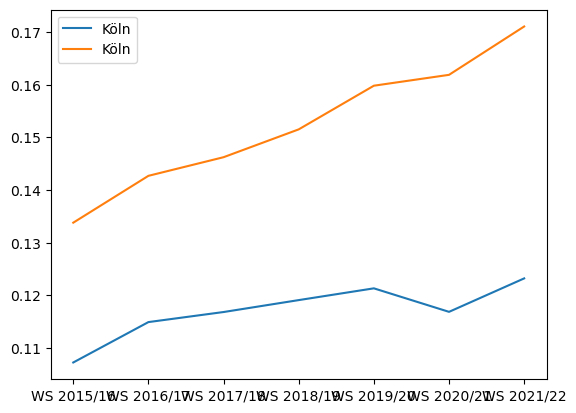

In [ ]:
plt.plot(ratio_international['      Köln, kreisfreie Stadt'],label='Köln')
plt.plot(ratio_international['    Köln, Regierungsbezirk'],label='Köln')
plt.legend()

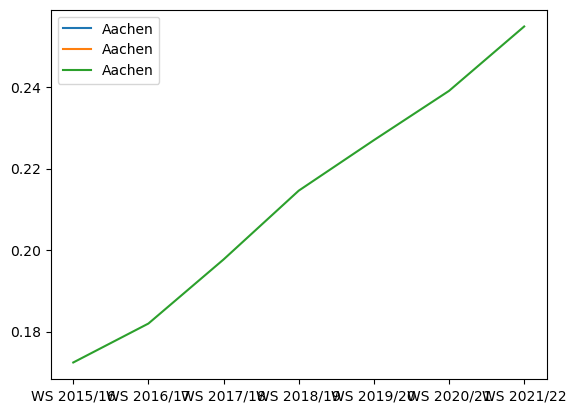

In [ ]:
plt.plot(ratio_international['      Aachen, kreisfreie Stadt'],label='Aachen')
plt.plot(ratio_international['      Aachen, Kreis'],label='Aachen')
plt.plot(ratio_international['      Städteregion Aachen, Kreis'],label='Aachen')
plt.legend()

## merge with geodataframe

In [173]:
gdf_merged = pd.merge(left=gdf, right=ratio_international, left_on='AGS', right_on='Kreise und kreisfreie Städte_Code')
gdf_merged.ratio_international

0      0.081928
1      0.087525
2      0.098700
3           NaN
4      0.043993
         ...   
395         NaN
396         NaN
397         NaN
398         NaN
399         NaN
Name: ratio_international, Length: 400, dtype: float64

In [175]:
gdf_merged.ratio_international.dropna()

0      0.081928
1      0.087525
2      0.098700
4      0.043993
8      0.039581
         ...   
382    0.290309
384    0.165913
385    0.012766
388    0.314863
392    0.343424
Name: ratio_international, Length: 227, dtype: float64

In [176]:
ratio_international.dropna()

Kreise und kreisfreie Städte        Kreise und kreisfreie Städte_Code  Semester  
      Ahrweiler, Landkreis          07131                              WS 2021/22    0.208560
      Altötting, Landkreis          09171                              WS 2021/22    0.097345
      Amberg, kreisfreie Stadt      09361                              WS 2021/22    0.071561
      Anhalt-Bitterfeld, Landkreis  15082                              WS 2021/22    0.359893
      Ansbach, Landkreis            09571                              WS 2021/22    0.085781
                                                                                       ...   
  Sachsen                           14                                 WS 2021/22    0.172007
  Sachsen-Anhalt                    15                                 WS 2021/22    0.171899
  Schleswig-Holstein                01                                 WS 2021/22    0.082910
  Thüringen                         16                                 W

In [177]:
ags_missings=[]
for ags in ratio_international.dropna().index.get_level_values(1):
    if len(gdf_merged[gdf_merged.AGS==ags])==0:
        ags_missings.append(ags)
        print(ratio_international.dropna()[ratio_international.dropna().index.get_level_values(1)==ags])

Kreise und kreisfreie Städte      Kreise und kreisfreie Städte_Code  Semester  
      Hannover, Landeshauptstadt  03241001                           WS 2021/22    0.154274
Name: ratio_international, dtype: float64
Kreise und kreisfreie Städte    Kreise und kreisfreie Städte_Code  Semester  
    Arnsberg, Regierungsbezirk  059                                WS 2021/22    0.127214
Name: ratio_international, dtype: float64
Kreise und kreisfreie Städte           Kreise und kreisfreie Städte_Code  Semester  
    Braunschweig, Statistische Region  031                                WS 2021/22    0.171033
Name: ratio_international, dtype: float64
Kreise und kreisfreie Städte       Kreise und kreisfreie Städte_Code  Semester  
    Chemnitz, Statistische Region  145                                WS 2021/22    0.273593
Name: ratio_international, dtype: float64
Kreise und kreisfreie Städte     Kreise und kreisfreie Städte_Code  Semester  
    Darmstadt, Regierungsbezirk  064                     

In [178]:
len(ags_missings)

45

In [ ]:
for reg in gdf.GEN:
    if 'Braunschweig' in reg:
        print(reg, gdf[gdf.GEN==reg].AGS)

Braunschweig 16    03101
Name: AGS, dtype: object


In [ ]:
gdf_merged[gdf_merged.AGS=='03101'].ratio_international

16    0.180156
Name: ratio_international, dtype: float64

In [ ]:
gdf[gdf.GEN=='Hannover, Landeshauptstadt'].AGS

Series([], Name: AGS, dtype: object)

In [ ]:
gdf_merged[gdf_merged.GEN=='Ahrweiler'].ratio_international

143    0.20856
Name: ratio_international, dtype: float64

<Axes: >

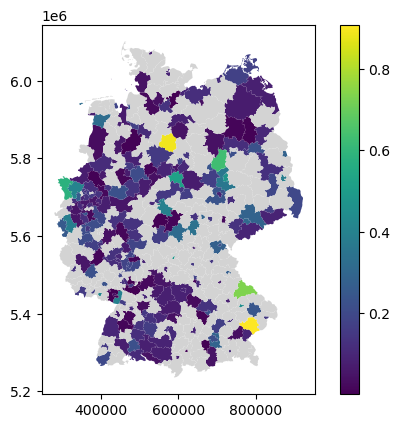

In [179]:
gdf_merged.plot('ratio_international',legend=True, missing_kwds={'color': 'lightgrey'})

Likely, the missings would need to be treated with more care. The outliers are due to small numbers of total students:

In [78]:
ratio_international[ratio_international>=0.5]

Kreise und kreisfreie Städte      Kreise und kreisfreie Städte_Code  Semester  
      Celle, Landkreis            03351                              WS 2021/22    0.890110
      Cham, Landkreis             09372                              WS 2021/22    0.734899
      Goslar, Landkreis           03153                              WS 2021/22    0.519153
      Jerichower Land, Landkreis  15086                              WS 2021/22    0.630000
      Kleve, Kreis                05154                              WS 2021/22    0.581930
      Rottal-Inn, Landkreis       09277                              WS 2021/22    0.908920
Name: ratio_international, dtype: float64

In [82]:
students.data[(students.data['Kreise und kreisfreie Städte_Code']=='03351')
              & (students.data['Geschlecht']=='Insgesamt')
              & (students.data['Nationalität (inkl. insgesamt)']=='Ausländer/-innen')
              & (students.data['Fächergruppe (mit Insgesamt)']=='Insgesamt')]

,Semester,Kreise und kreisfreie Städte,Geschlecht,Nationalität (inkl. insgesamt),Fächergruppe (mit Insgesamt),Kreise und kreisfreie Städte_Code,Geschlecht_Code,Nationalität (inkl. insgesamt)_Code,Fächergruppe (mit Insgesamt)_Code,Studierende_(im_Kreisgebiet)
3799,WS 2021/22,"Celle, Landkreis",Insgesamt,Ausländer/-innen,Insgesamt,03351,INSGESAMT,NATA,INSGESAMT,81.0


# Relate to population

## rename columns of interest

In [11]:
students.metadata

{'Ident': {'Service': 'metadata', 'Method': 'table'},
 'Status': {'Code': 0, 'Content': 'erfolgreich', 'Type': 'Information'},
 'Parameter': {'username': '********************',
  'password': '********************',
  'name': '21311-01-01-4',
  'area': 'Alle',
  'language': 'de'},
 'Object': {'Code': '21311-01-01-4',
  'Content': 'Studierende nach Geschlecht, Nationalität und\nFächergruppen - regionale Tiefe: Kreise und krfr. Städte',
  'Time': {'From': 'WS 2015/16', 'To': 'WS 2021/22'},
  'Valid': 'false',
  'Structure': {'Head': {'Code': '21311',
    'Content': 'Statistik der Studenten',
    'Type': 'Statistik',
    'Values': None,
    'Selected': None,
    'Structure': [{'Code': 'HS-W02',
      'Content': 'Studierende (im Kreisgebiet)',
      'Type': 'Merkmal',
      'Values': None,
      'Selected': None,
      'Structure': None,
      'Updated': 'see parent'}],
    'Updated': 'see parent'},
   'Columns': [{'Code': 'SEMEST',
     'Content': 'Semester',
     'Type': 'Merkmal',
     

In [12]:
df_students.rename(
    columns={
        '1_Auspraegung_Label': 'region', 
        '1_Auspraegung_Code': 'ags',
        '2_Auspraegung_Label': 'geschlecht', 
        '3_Auspraegung_Label': 'nation', 
        '4_Auspraegung_Label': 'fach', 
        'HS-W02__Studierende_(im_Kreisgebiet)__Anzahl': 'studierende',
    },
    inplace=True
)

In [13]:
df_population.rename(
    columns={
        '1_Auspraegung_Label': 'region', 
        '1_Auspraegung_Code': 'ags',
        '2_Auspraegung_Label': 'geschlecht', 
        'BEVSTD__Bevoelkerungsstand__Anzahl': 'population'
    },
    inplace=True,
)

## get column types consistent

In [14]:
df_population.population.astype('float')

ValueError: could not convert string to float: '-'

In [15]:
df_students.studierende.replace(to_replace='-',value=0,inplace=True)
df_students.studierende.replace(to_replace='.',value=None,inplace=True)

df_population.population.replace(to_replace='-',value=0,inplace=True)
df_population.population.replace(to_replace='.',value=None,inplace=True)

In [16]:
df_students.studierende = df_students.studierende.astype(float)
df_population.population = df_population.population.astype(float)

In [17]:
df_students.ags = df_students.ags.astype(str)
df_population.ags = df_population.ags.astype(str)

In [18]:
df_students[df_students.ags == '05354']

,Statistik_Code,Statistik_Label,Zeit_Code,Zeit_Label,Zeit,1_Merkmal_Code,1_Merkmal_Label,ags,region,2_Merkmal_Code,...,geschlecht,3_Merkmal_Code,3_Merkmal_Label,3_Auspraegung_Code,nation,4_Merkmal_Code,4_Merkmal_Label,4_Auspraegung_Code,fach,studierende
8730,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG01,Geisteswissenschaften,0.0
8731,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG02,Sport,0.0
8732,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG03,"Rechts-, Wirtschafts- und Sozialwissenschaften",0.0
8733,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG04,Mathematik/Naturwissenschaften,0.0
8734,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG05,Humanmedizin/Gesundheitswissenschaften,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,weiblich,NAT01,Nationalität (inkl. insgesamt),NATD,Deutsche,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG07,"Agrar-, Forst- und Ernährungswissensch., Veterinär",0.0
8816,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,weiblich,NAT01,Nationalität (inkl. insgesamt),NATD,Deutsche,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG08,Ingenieurwissenschaften,0.0
8817,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,weiblich,NAT01,Nationalität (inkl. insgesamt),NATD,Deutsche,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG09,"Kunst, Kunstwissenschaft",0.0
8818,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,weiblich,NAT01,Nationalität (inkl. insgesamt),NATD,Deutsche,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG10,Außerhalb der Studienbereichsgliederung,0.0


## only interested in total numbers of students and population

In [19]:
idx_total = df_students[(df_students.nation=='Insgesamt')&(df_students.geschlecht=='Insgesamt')&(df_students.fach=='Insgesamt')].index
df_students_totals = df_students.loc[idx_total,['region','ags','studierende']]

In [20]:
idx_total = df_population[df_population.geschlecht=='Insgesamt'].index
df_population_totals = df_population.loc[idx_total,['region','ags','population']]

In [21]:
df_students_totals

,region,ags,studierende
9,Deutschland,DG,2941915.0
99,Schleswig-Holstein,01,67447.0
189,"Flensburg, kreisfreie Stadt",01001,9960.0
279,"Kiel, kreisfreie Stadt",01002,36321.0
369,"Lübeck, kreisfreie Stadt, Hansestadt",01003,13850.0
...,...,...,...
47979,"Saalfeld-Rudolstadt, Landkreis",16073,0.0
48069,Saale-Holzland-Kreis,16074,0.0
48159,Saale-Orla-Kreis,16075,0.0
48249,"Greiz, Landkreis",16076,0.0


In [22]:
df_population_totals

,region,ags,population
0,Deutschland,DG,84358845.0
3,Schleswig-Holstein,01,2953270.0
6,"Flensburg, kreisfreie Stadt",01001,92550.0
9,"Kiel, kreisfreie Stadt",01002,247717.0
12,"Lübeck, kreisfreie Stadt, Hansestadt",01003,218095.0
...,...,...,...
1599,"Saalfeld-Rudolstadt, Landkreis",16073,101494.0
1602,Saale-Holzland-Kreis,16074,83234.0
1605,Saale-Orla-Kreis,16075,79178.0
1608,"Greiz, Landkreis",16076,96381.0


## Merge population and student data

In [23]:
df_students_pops = pd.merge(df_students_totals, df_population_totals, on=['region', 'ags'],how='outer')

In [24]:
df_students_pops

,region,ags,studierende,population
0,Deutschland,DG,2941915.0,84358845.0
1,Schleswig-Holstein,01,67447.0,2953270.0
2,"Flensburg, kreisfreie Stadt",01001,9960.0,92550.0
3,"Kiel, kreisfreie Stadt",01002,36321.0,247717.0
4,"Lübeck, kreisfreie Stadt, Hansestadt",01003,13850.0,218095.0
...,...,...,...,...
533,"Saalfeld-Rudolstadt, Landkreis",16073,0.0,101494.0
534,Saale-Holzland-Kreis,16074,0.0,83234.0
535,Saale-Orla-Kreis,16075,0.0,79178.0
536,"Greiz, Landkreis",16076,0.0,96381.0


In [25]:
df_students_pops['rate']=df_students_pops.studierende/df_students_pops.population*10000
df_students_pops

,region,ags,studierende,population,rate
0,Deutschland,DG,2941915.0,84358845.0,348.738179
1,Schleswig-Holstein,01,67447.0,2953270.0,228.380744
2,"Flensburg, kreisfreie Stadt",01001,9960.0,92550.0,1076.175041
3,"Kiel, kreisfreie Stadt",01002,36321.0,247717.0,1466.229609
4,"Lübeck, kreisfreie Stadt, Hansestadt",01003,13850.0,218095.0,635.044361
...,...,...,...,...,...
533,"Saalfeld-Rudolstadt, Landkreis",16073,0.0,101494.0,0.000000
534,Saale-Holzland-Kreis,16074,0.0,83234.0,0.000000
535,Saale-Orla-Kreis,16075,0.0,79178.0,0.000000
536,"Greiz, Landkreis",16076,0.0,96381.0,0.000000


In [26]:
df_students_pops.rate

0       348.738179
1       228.380744
2      1076.175041
3      1466.229609
4       635.044361
          ...     
533       0.000000
534       0.000000
535       0.000000
536       0.000000
537       0.000000
Name: rate, Length: 538, dtype: float64

## check some special cases - Stadtstaaten, Landeshaupstadt, ..

In [27]:
for reg,ags in zip(df_students_pops.region,df_students_pops.ags):
    if len(ags)!=5:
        print(reg,ags)

Deutschland DG
  Schleswig-Holstein 01
  Hamburg 02
  Niedersachsen 03
    Braunschweig, Statistische Region 031
    Hannover, Statistische Region 032
      Hannover, Landeshauptstadt 03241001
    Lüneburg 033
    Weser-Ems, Statistische Region 034
  Bremen 04
  Nordrhein-Westfalen 05
    Düsseldorf, Regierungsbezirk 051
    Köln, Regierungsbezirk 053
      Aachen, kreisfreie Stadt 05334002
    Münster, Regierungsbezirk 055
    Detmold, Regierungsbezirk 057
    Arnsberg, Regierungsbezirk 059
  Hessen 06
    Darmstadt, Regierungsbezirk 064
    Gießen, Regierungsbezirk 065
    Kassel, Regierungsbezirk 066
  Rheinland-Pfalz 07
    Koblenz, Statistische Region 071
    Trier, Statistische Region 072
    Rheinhessen-Pfalz, Statistische Region 073
  Baden-Württemberg 08
    Stuttgart, Regierungsbezirk 081
    Karlsruhe, Regierungsbezirk 082
    Freiburg, Regierungsbezirk 083
    Tübingen, Regierungsbezirk 084
  Bayern 09
    Oberbayern, Regierungsbezirk 091
    Niederbayern, Regierungsbezirk 

In [28]:
for idx in df_population_totals.index:
    if 'Berlin' in df_population_totals.loc[idx].region:
        print(df_population_totals.loc[idx])

region           Berlin
ags                  11
population    3755251.0
Name: 1098, dtype: object
region              Berlin-Mitte
ags                     11001001
population                   NaN
Name: 1101, dtype: object
region              Berlin-Friedrichshain-Kreuzberg
ags                                        11002002
population                                      NaN
Name: 1104, dtype: object
region              Berlin-Pankow
ags                      11003003
population                    NaN
Name: 1107, dtype: object
region              Berlin-Charlottenburg-Wilmersdorf
ags                                          11004004
population                                        NaN
Name: 1110, dtype: object
region              Berlin-Spandau
ags                       11005005
population                     NaN
Name: 1113, dtype: object
region              Berlin-Steglitz-Zehlendorf
ags                                   11006006
population                                 NaN
Name: 1

In [29]:
for idx in df_students_totals.index:
    if 'Berlin' in df_students_totals.loc[idx].region:
        print(df_students_totals.loc[idx])

region           Berlin
ags                  11
studierende    203869.0
Name: 32949, dtype: object
region               Berlin-Mitte
ags                      11001001
studierende                   NaN
Name: 33039, dtype: object
region               Berlin-Friedrichshain-Kreuzberg
ags                                         11002002
studierende                                      NaN
Name: 33129, dtype: object
region               Berlin-Pankow
ags                       11003003
studierende                    NaN
Name: 33219, dtype: object
region               Berlin-Charlottenburg-Wilmersdorf
ags                                           11004004
studierende                                        NaN
Name: 33309, dtype: object
region               Berlin-Spandau
ags                        11005005
studierende                     NaN
Name: 33399, dtype: object
region               Berlin-Steglitz-Zehlendorf
ags                                    11006006
studierende                    

In [30]:
for idx in df_students_pops.index:
    if 'Berlin' in df_students_pops.loc[idx].region:
        print(df_students_pops.loc[idx])

region             Berlin
ags                    11
studierende      203869.0
population      3755251.0
rate           542.890475
Name: 366, dtype: object
region               Berlin-Mitte
ags                      11001001
studierende                   NaN
population                    NaN
rate                          NaN
Name: 367, dtype: object
region               Berlin-Friedrichshain-Kreuzberg
ags                                         11002002
studierende                                      NaN
population                                       NaN
rate                                             NaN
Name: 368, dtype: object
region               Berlin-Pankow
ags                       11003003
studierende                    NaN
population                     NaN
rate                           NaN
Name: 369, dtype: object
region               Berlin-Charlottenburg-Wilmersdorf
ags                                           11004004
studierende                                       

In [31]:
for idx in gdf.index:
    if 'Hamburg' in gdf.loc[idx].GEN:
        print(gdf.loc[idx].AGS)

02000


In [32]:
df_students_pops.loc[df_students_pops.ags=='11','ags']='11000'
df_students_pops.loc[df_students_pops.ags=='02','ags']='02000'

In [33]:
df_students_pops.loc[df_students_pops.ags=='04011']

,region,ags,studierende,population,rate
72,"Bremen, kreisfreie Stadt",04011,34577.0,569396.0,607.257515


In [34]:
for idx in df_students_pops.index:
    if 'Köln' in df_students_pops.loc[idx].region:
        print(df_students_pops.loc[idx])

region             Köln, Regierungsbezirk
ags                                   053
studierende                      229880.0
population                      4527594.0
rate                           507.731038
Name: 91, dtype: object
region               Köln, kreisfreie Stadt
ags                                   05315
studierende                        104383.0
population                        1084831.0
rate                             962.205173
Name: 93, dtype: object


In [35]:
for idx in gdf.index:
    if 'Köln' in gdf.loc[idx].GEN:
        print(gdf.loc[idx].AGS)

05315


# Merge data and shape file and plot

In [36]:
gdf_merged = gdf.merge(df_students_pops, left_on='AGS', right_on='ags', how='inner')

<Axes: >

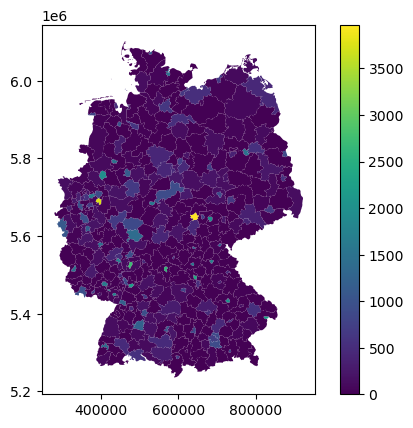

In [42]:
gdf_merged.plot('rate',legend=True)

In [40]:
gdf_merged.plot?

Signature:      gdf_merged.plot(*args, **kwargs)
Type:           GeoplotAccessor
String form:    <geopandas.plotting.GeoplotAccessor object at 0x124409850>
File:           ~/miniforge3/envs/pystatis/lib/python3.11/site-packages/geopandas/plotting.py
Docstring:     
Plot a GeoDataFrame.

Generate a plot of a GeoDataFrame with matplotlib.  If a
column is specified, the plot coloring will be based on values
in that column.

Parameters
----------
column : str, np.array, pd.Series (default None)
    The name of the dataframe column, np.array, or pd.Series to be plotted.
    If np.array or pd.Series are used then it must have same length as
    dataframe. Values are used to color the plot. Ignored if `color` is
    also set.
kind: str
    The kind of plots to produce. The default is to create a map ("geo").
    Other supported kinds of plots from pandas:

    - 'line' : line plot
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : BoxPlot

In [287]:
gdf_merged.ags

0      01001
1      01002
2      01003
3      01004
4      01051
       ...  
395    16073
396    16074
397    16075
398    16076
399    16077
Name: ags, Length: 400, dtype: object

In [286]:
gdf.AGS

0      01001
1      01002
2      01003
3      01004
4      01051
       ...  
395    16073
396    16074
397    16075
398    16076
399    16077
Name: AGS, Length: 400, dtype: object